# Homework \#5
Due July 29 @ 11:59pm

## Submission requirements
Upload a **single PDF file** of your IJulia notebook for this entire assigment. Clearly denote which question each section of your PDF corresponds to.

## Problem 1 -- Nonconvex Quadratics

Suppose you have the constraint:

$2x^2 + y^2+ 2z^2 - 3xy + xz - 4yz \leq 0 \quad\quad$ (1)

(a)  Write constraint (1) in the standard form $v^TQv\leq 0$ where $Q$ is a symmetric matrix.  What is $Q$ and what is $v$?




**Ans:** vector $v = [x, y, z]$ , symmetric matrix $Q$ is 
$\begin {bmatrix} 2\quad-1.5\quad0.5 \\ -1.5\quad1\quad-2 \\ 0.5\quad-2\quad2 \end {bmatrix}$<br>
contstraint is $v^TQv\leq 0$.

(b)  This constraint is not convex (i.e., the set of points satisfying the constraint is not an ellipsoid). Explain why this is the case. *Hint*: You can perform an orthogonal decomposition of a symmetric matrix $Q$ in Julia like this: 

In [36]:
Q = [2 -1.5 0.5; -1.5 1 -2; 0.5 -2 2]

using LinearAlgebra
(L,U) = (eigvals(Q),eigvecs(Q)) # L is the vector of eigenvalues and U is orthogonal
U * Diagonal(L) * U' # this is equal to Q (as long as Q was symmetric to begin with)

#take the square root of Diagonal(L) if all of its eigenvalues are non-negative
P = U * sqrt(Diagonal(L))
println(P)

DomainError: DomainError with -0.8701601197116661:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

**Ans:** The constraint is convex if and only if the matrix Q is symmetric and positive semidefinite. Since Q is not positive semidefinite for that we cannot take the sqaure root of it, the constraint is not convex.


(c)  We can write constraint (1) in norm format as follows:

$‖Av‖_2^2−‖Bv‖_2^2\leq 0 \quad\quad$ (2) 

Find matrices $A$ and $B$ that make this constraint equivalent to (1).




**Ans:** $‖Av‖_2^2−‖Bv‖_2^2\leq 0$ is equivalent to $(v^TA^TAv) - (v^TB^TBv) \leq 0$, hence equivalent to $v^T(A^TA - B^TB)v \leq 0$. Therefore, $Q=A^TA - B^TB$. Solve this using julia.

In [74]:
println(Diagonal(L))
#diagonize L and turn it into L_pos - L_neg
L_pos = [0.0 0.0 0.0; 0.0 1.518494119904299 0.0; 0.0 0.0 4.351665999807366]
L_neg = [-0.8701601197116661 0.0 0.0; 0.0 0 0.0; 0.0 0.0 0]

A = U * sqrt(L_pos)
B = U * sqrt(L_neg)
println("A is " ,A)
println("B is " ,B)
println(A*A'-B*B') # check: it should equals Q

[-0.8701601197116661 0.0 0.0; 0.0 1.518494119904299 0.0; 0.0 0.0 4.351665999807366]
A is [0.0 -0.9764959351583015 1.0685819183944123; -0.0 -0.06381999098002426 -1.2462660599533772; 0.0 0.7489170963964722 1.2870973511340034]
B is Complex{Float64}[0.0 - 0.3088877266907329im 0.0 + 0.0im 0.0 + 0.0im; -0.0 - 0.7464931904849552im -0.0 - 0.0im -0.0 - 0.0im; 0.0 - 0.46636510222259325im 0.0 + 0.0im 0.0 + 0.0im]
Complex{Float64}[1.9999999999999993 - 0.0im -1.5000000000000022 - 0.0im 0.499999999999999 - 0.0im; -1.5000000000000022 - 0.0im 0.9999999999999974 - 0.0im -1.9999999999999976 - 0.0im; 0.499999999999999 - 0.0im -1.9999999999999976 - 0.0im 2.0000000000000004 - 0.0im]


(d)  Explain how to find $(x, y, z)$ that satisfy the above constraint but make $2x^2+ y^2 + 2z^2$ arbitrarily large.

**Ans:** Define $w = U^Tx$,  $x^TQx = \lambda_{1}w_{1}^2 + \lambda_{2}w_{2}^2 + \lambda_{3}w_{3}^2$, since $x^TQx \leq 0$ and $\lambda_{1} < 0$, $w_{2} = w_{3} = 0$. $w_{1} = a_{11}x + a_{12}y + a_{13}z$, then $2x^2+ y^2 + 2z^2$ can be arbitrarily large.

## Problem 2 -- Circles within Circles

Formulate a convex program to solve the minimum enclosing ball (MEB) problem.  You need to determine the center \$z\$ of a ball, and its radius \$d\$ so that each of the circles centered at \$c_i\$ with radius \$r_i\$ are enclosed in your generated circle.  Your task is to find the cirle of smallest radius that encircles all the other circles.

You can use the following code to start building your model. Start with $n=5$ circles to help with debugging, but display the output of your model for both $n=5$ and a very large value of $n$, such as $n=200$.

 Resolving package versions...


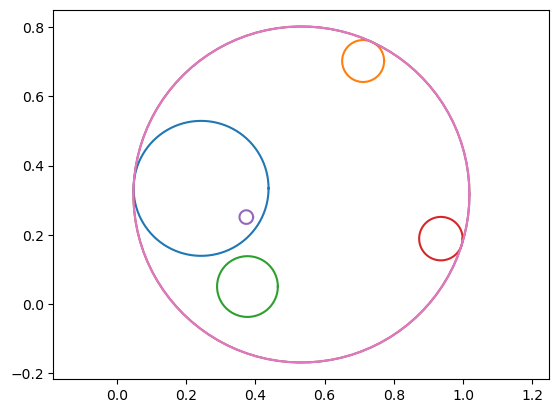

  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       15
Number of nonzeros in Lagrangian Hessian.............:       16

Total number of variables............................:        3
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequalit

In [52]:
n = 5
using Random, PyPlot
r = [rand()*0.2 for i in 1:n] # randomly generate n radii with length between 0 and 0.2
# randomly generate n points with (x,y) coords between 0 and 1
c = [rand() for i in 1:n, j in 1:2] 

t = range(0,stop=2*pi,length=100) # parameter that traverses the circle

# for each of the n points
for i in 1:n
    # plot circle radius r[i] with center (x[i],y[i])
    plot( c[i,1] .+ r[i]*cos.(t), c[i,2] .+ r[i]*sin.(t)) 
end

axis("equal"); # make x and y scales equal

#build model
using Pkg
Pkg.add("Ipopt")
using JuMP,Ipopt

m = Model(Ipopt.Optimizer)

@variable(m, x[1:2])# variable for coordinates of circle center
@variable(m, d>=0)# variable representing radius of the circle

@NLobjective(m, Min, pi*(d^2))# we want to minimize the area

@NLconstraint(m, constr[i in 1:n], (x[1]-c[i,1])^2 + (x[2]-c[i,2])^2 <= (d-r[i])^2 )

optimize!(m)
t=range(0,stop=2pi,length=100)# parameter that traverses the circle
# plot circle radius d with center (x1,x2); (orange circe)
plot( value(x[1]).+ value(d)*cos.(t), value(x[2]).+ value(d)*sin.(t));



 Resolving package versions...


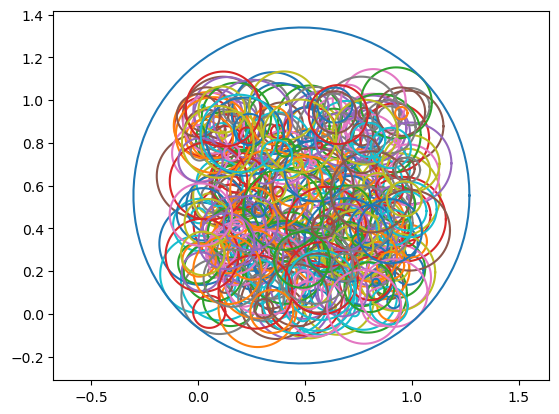

  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:     1201

Total number of variables............................:        3
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequalit

In [58]:
n = 400
using Random, PyPlot
r = [rand()*0.2 for i in 1:n] # randomly generate n radii with length between 0 and 0.2
# randomly generate n points with (x,y) coords between 0 and 1
c = [rand() for i in 1:n, j in 1:2] 

t = range(0,stop=2*pi,length=100) # parameter that traverses the circle

# for each of the n points
for i in 1:n
    # plot circle radius r[i] with center (x[i],y[i])
    plot( c[i,1] .+ r[i]*cos.(t), c[i,2] .+ r[i]*sin.(t)) 
end

axis("equal"); # make x and y scales equal

#build model
using Pkg
Pkg.add("Ipopt")
using JuMP,Ipopt

m = Model(Ipopt.Optimizer)

@variable(m, x[1:2])# variable for coordinates of circle center
@variable(m, d>=0)# variable representing radius of the circle

@NLobjective(m, Min, pi*(d^2))# we want to minimize the area

@NLconstraint(m, constr[i in 1:n], (x[1]-c[i,1])^2 + (x[2]-c[i,2])^2 <= (d-r[i])^2 )

optimize!(m)
t=range(0,stop=2pi,length=100)# parameter that traverses the circle
# plot circle radius d with center (x1,x2); 
plot( value(x[1]).+ value(d)*cos.(t), value(x[2]).+ value(d)*sin.(t));

